# Chiller Characteristics

### Vapor compression refrigeration cycle
<img src="chiller.png" style="float: center;" width=300/>

|Process|Description|
|:---:|:-----|
|$1 \rightarrow 2$|Isentropic compression of saturated vapor|
|$2 \rightarrow 3$|Isobaric heat rejection in condenser to get liquid|
|$3 \rightarrow 4$|Isenthalpic expansion of saturated liquid in throttler|
|$4 \rightarrow 1$|Isobaric heat extraction in the evaporator|

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.optimize
import scipy.interpolate
from scipy.constants import R
from matplotlib import style
from matplotlib.ticker import StrMethodFormatter

from IPython.display import display, Math
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

style.use("classic")

In [2]:
Pc = 49.9e5 # critical pressure in Pa
Tc = 369.3  # critical temperature in K
omega = 0.221

Ttr = 115.73 # triple point K 
Ptr = 0.3794747321972858 # Pa

flow_rate = 6.93 # m3/hr

rho = 40.7 # kg/m3
MW = 86.468 # g/mol
Cp = 1 # kJ/kg.K

a = 0.45724 * R ** 2 * Tc ** 2 / Pc
b = 0.07780 * R * Tc / Pc

latent_heat = (np.log(Pc) - np.log(Ptr)) / (1 / Ttr - 1 / Tc) * R * 1e-3

print("a = %0.3e Pa.(m3/mol)^2" % a)
print("b = %0.3e m3/mol" % b)
print("Latent heat = %0.3f kJ/gmol" % latent_heat)

a = 8.639e-01 Pa.(m3/mol)^2
b = 4.787e-05 m3/mol
Latent heat = 22.972 kJ/gmol


###  Peng-Robinson Equation

$$P = \frac{RT}{V-b} - \frac{a\alpha}{V^2 + 2Vb - b^2}$$

where $\alpha = (1+(0.37464 + 1.54226 \omega - 0.26992 \omega^2)(1 - T_r^{1/2}))^2$

<br>
The departure functions are:
$$\frac{\partial P}{\partial T}\bigg|_V = \frac{R}{V-b} - \frac{a}{V^2 + 2Vb - b^2}\frac{d\alpha}{dT}$$

where $\frac{d\alpha}{dT} = \frac{-\sqrt{\alpha}(0.37464 + 1.54226 \omega - 0.26992 \omega^2)}{\sqrt{T}}$

$$S^{res} = R \ln{\frac{P(V-b)}{RT}} - a\frac{d\alpha}{dT}\times\frac{1}{2\sqrt{2}b}\ln{\frac{V+(1-\sqrt{2})b}{V+(1+\sqrt{2})b}}$$

$$H^{res} = PV - RT + a(\alpha - \frac{d\alpha}{dT})\times\frac{1}{2\sqrt{2}b}\ln{\frac{V+(1-\sqrt{2})b}{V+(1+\sqrt{2})b}}$$

$$G^{res} = PV - RT -RT\ln{\frac{PV}{RT}} -RT\ln{\frac{V-b}{V}}+ \frac{a\alpha}{2\sqrt{2}b}\ln{\frac{V+(1-\sqrt{2})b}{V+(1+\sqrt{2})b}}$$

<br>
$$M_2 - M_1 = M_2^{res} - M_1^{res} + M_2^* - M_1^*$$

$$S_2^* - S_1^* = \int_{T_1}^{T_2} \frac{C_p}{T}dT$$

$$H_2^* - H_1^* = \int_{T_1}^{T_2} C_pdT$$

### Interpolation for $h_f$, $h_{fg}$, $h_g$ from saturation tables

In [3]:
x = np.arange(10 + 273.15, 51 + 273.15, 1)
yg = [408.6, 408.9, 409.2, 409.5, 409.9, 410.2, 410.5, 410.8, 411.1, 411.4, 411.7, 411.9, 412.2, 412.5, 412.8, 413.0, 413.3, 413.5, 413.8, 414.0, 414.3, 414.5, 414.7, 414.9, 415.1, 415.3, 415.5, 415.7, 415.9, 416.1, 416.2, 416.4, 416.6, 416.7, 416.8, 417.0, 417.1, 417.2, 417.3, 417.4, 417.4]
yfg = [196.7, 195.8, 194.9, 194.0, 193.2, 192.3, 191.4, 190.4, 189.5, 188.6, 187.6, 186.6, 185.7, 184.7, 183.8, 182.7, 181.8, 180.7, 179.7, 178.7, 177.7, 176.6, 175.5, 174.4, 173.3, 172.2, 171.1, 170.0, 168.9, 167.8, 166.6, 165.4, 164.3, 163.0, 161.8, 160.6, 159.4, 158.1, 156.8, 155.5, 154.2]
hg = scipy.interpolate.UnivariateSpline(x, yg, k=1, s=0)
hfg = scipy.interpolate.UnivariateSpline(x, yfg, k=1, s=0)

In [4]:
def VCRC(T1, T2, T3, I):
    ### T1, T2, T3 in K
    ### I in A
    
    def Hres(P, V, T):
        # Residual enthalpy
        Tr = T / Tc
        alpha = (1 + (0.37464 + 1.54226 * omega - 0.26992 * omega ** 2) * (1 - Tr ** 0.5)) ** 2

        dalphadT = -alpha * (0.37464 + 1.54226 * omega - 0.26992 * omega ** 2) / np.sqrt(T)
        return P * V - R * T + a * (alpha - dalphadT) / (2 ** 1.5 * b) * np.log((V + (1 - 2 ** 0.5) * b) / (V + (1 + 2 ** 0.5) * b))

    def Sres(P, V, T):
        # Residual entropy
        Tr = T / Tc
        alpha = (1 + (0.37464 + 1.54226 * omega - 0.26992 * omega ** 2) * (1 - Tr ** 0.5)) ** 2

        dalphadT = -alpha * (0.37464 + 1.54226 * omega - 0.26992 * omega ** 2) / np.sqrt(T)
        return R * np.log(P * (V - b) / (R * T)) - a * dalphadT / (2 ** 1.5 * b) * np.log((V + (1 - 2 ** 0.5) * b) / (V + (1 + 2 ** 0.5) * b))

    def get_volume(P, T):
        def PR_EOS(V):
            Tr = T / Tc
            alpha = (1 + (0.37464 + 1.54226 * omega - 0.26992 * omega ** 2) * (1 - Tr ** 0.5)) ** 2
            return R * T / (V - b) - a * alpha / (V ** 2 + 2 * V * b - b ** 2) - P

        Vl = scipy.optimize.fsolve(PR_EOS, 1.2 * b, maxfev=1000000)[0]    # liquid volume
        Vv = scipy.optimize.fsolve(PR_EOS, R * T / P, maxfev=1000000)[0]  # gas volume
        return [Vv, Vl]

    def Gv_minus_Gl(P, T):
        [Vv, Vl] = get_volume(P, T)
        Tr = T / Tc
        alpha = (1 + (0.37464 + 1.54226 * omega - 0.26992 * omega ** 2) * (1 - Tr ** 0.5)) ** 2

        dalphadT = -alpha * (0.37464 + 1.54226 * omega - 0.26992 * omega ** 2) / np.sqrt(T)
        err = P * (Vv - Vl) - R * T * np.log((Vv - b)/(Vl - b)) + a * alpha / (2 ** 1.5 * b) * np.log((Vv + (1 - 2 ** 0.5) * b) * (Vl + (1 + 2 ** 0.5) * b)/ ((Vv + (1 + 2 ** 0.5) * b) * (Vl + (1 - 2 ** 0.5) * b)))
        return err
    
    # set Gv - Gl = 0 to get saturation pressure
    P1 = scipy.optimize.fsolve(Gv_minus_Gl, 9e5, maxfev=1000000, args=(T1,))[0]
    [Vv1, Vl1] = get_volume(P1, T1)

    def isentropic(P, T):
        [Vv, Vl] = get_volume(P, T)
        S2_minus_S1 = Sres(P, Vv, T) - Sres(P1, Vv1, T1) + Cp * np.log(T / T1)
        return S2_minus_S1

    P2 = scipy.optimize.fsolve(isentropic, P1, maxfev=1000000, args=(T2,))[0]
    [Vv2, Vl2] = get_volume(P2, T2)

    P3 = scipy.optimize.fsolve(Gv_minus_Gl, 9e5, maxfev=1000000, args=(T3,))[0]
    P2 = P3
    [Vv3, Vl3] = get_volume(P3, T3)

    P4 = P1

    def isenthalpic(T, P):
        [Vv, Vl] = get_volume(P, T)
        H4_minus_H3 = Hres(P, Vl, T) - Hres(P3, Vl3, T3) + Cp * (T - T3)
        return H4_minus_H3

    T4 = scipy.optimize.fsolve(isenthalpic, T1, maxfev=1000000, args=(P4,))[0]
    [Vv4, Vl4] = get_volume(T4, P4)
    
    h1 = hg(T1) + 0.0
    h2 = hg(T2) + Cp * (T2 - T1)
    h4 = h1 - np.sqrt(3) * I * 240 / (1000 * rho * flow_rate / 3600)
    h3 = h4
    
    x3 = (h3 - (hg(T3) - hfg(T3))) / hfg(T3)
    x4 = 1 - (h1 - h4) / hfg(T1)
    
    P = [P1, P2, P3, P4]
    P_plt = [x / 1e3 for x in P]
    print("P in kPa:")
    print([round(x, 2) for x in P_plt])
    
    print("T in ˚C:")
    T = [T1, T2, T3, T4] 
    print([round(x - 273.15, 2) for x in T])
    
    print("h in kJ/kg:")
    h = [h1, h2, h3, h4]
    print([round(x, 2) for x in h])
    
    print("x3, x4")
    x = [x3, x4]
    print([round(x, 4) for x in x])
    
    print("COP")
    COP = (h1 - h4) / (h2 - h1)
    print(round(COP, 2))
    
    plt.figure(facecolor='white', figsize=(6, 6))
    plt.title("Pressure-Enthalpy Diagram")
    plt.plot(h,  P_plt, linewidth=1.2, color='black', marker='o')
    plt.plot([h[0], h[3]], [P_plt[0], P_plt[3]], linewidth=1.2, color='black' )
    plt.xlim(0.98 * min(h), 1.02 * max(h))
    plt.ylim(0.98 * min(P_plt), 1.02 * max(P_plt))
    plt.xlabel(r"$h\, (kJ/kg)$")
    plt.ylabel(r"$P\, (kPa)$")
    for i in range(4):
        plt.annotate(r'$%d$' % (i + 1), xy=(1.001 * h[i], 1.001 * P_plt[i]), fontsize=15)
        
    return round(COP, 2)

### Set 1

P in kPa:
[832.32, 1351.96, 1351.96, 832.32]
T in ˚C:
[17.0, 42.0, 35.0, 34.96]
h in kJ/kg:
[410.8, 441.6, 371.75, 371.75]
x3, x4
[0.7471, 0.7949]
COP
1.27


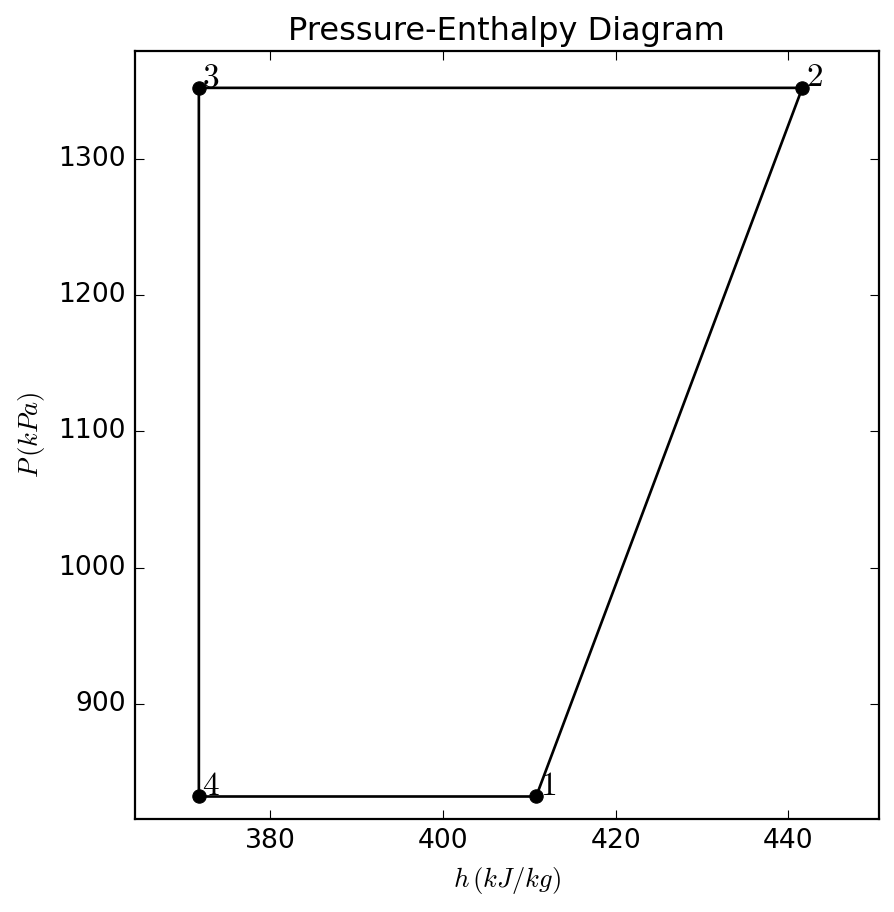

In [5]:
st1 = 19
T1 = 17 + 273.15
T2 = 42 + 273.15
T3 = 35 + 273.15
I = 7.36 
COP1 = VCRC(T1, T2, T3, I)

### Set 2

P in kPa:
[856.43, 1386.58, 1386.58, 856.43]
T in ˚C:
[18.0, 43.0, 36.0, 35.94]
h in kJ/kg:
[411.1, 441.7, 372.53, 372.53]
x3, x4
[0.7488, 0.7964]
COP
1.26


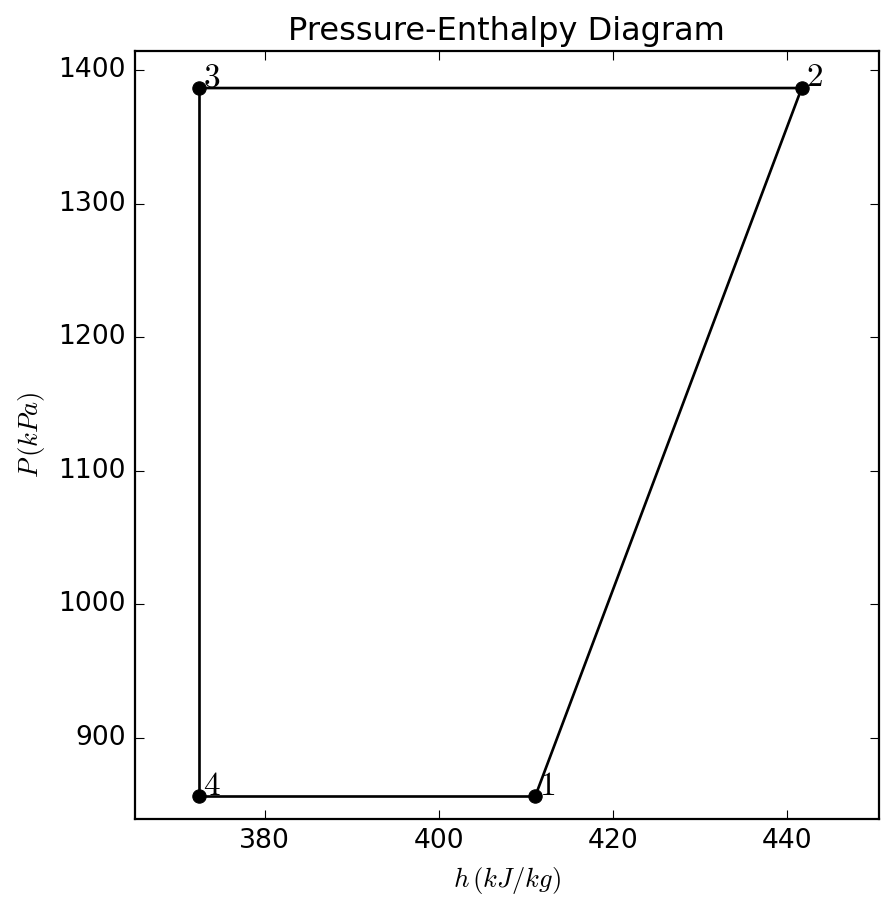

In [6]:
st2 = 17
T1 = 18 + 273.15
T2 = 43 + 273.15
T3 = 36 + 273.15
I = 7.27
COP2 = VCRC(T1, T2, T3, I)

### Set 3

P in kPa:
[881.06, 1421.85, 1421.85, 881.06]
T in ˚C:
[19.0, 44.0, 37.0, 36.92]
h in kJ/kg:
[411.4, 441.8, 372.4, 372.4]
x3, x4
[0.7453, 0.7932]
COP
1.28


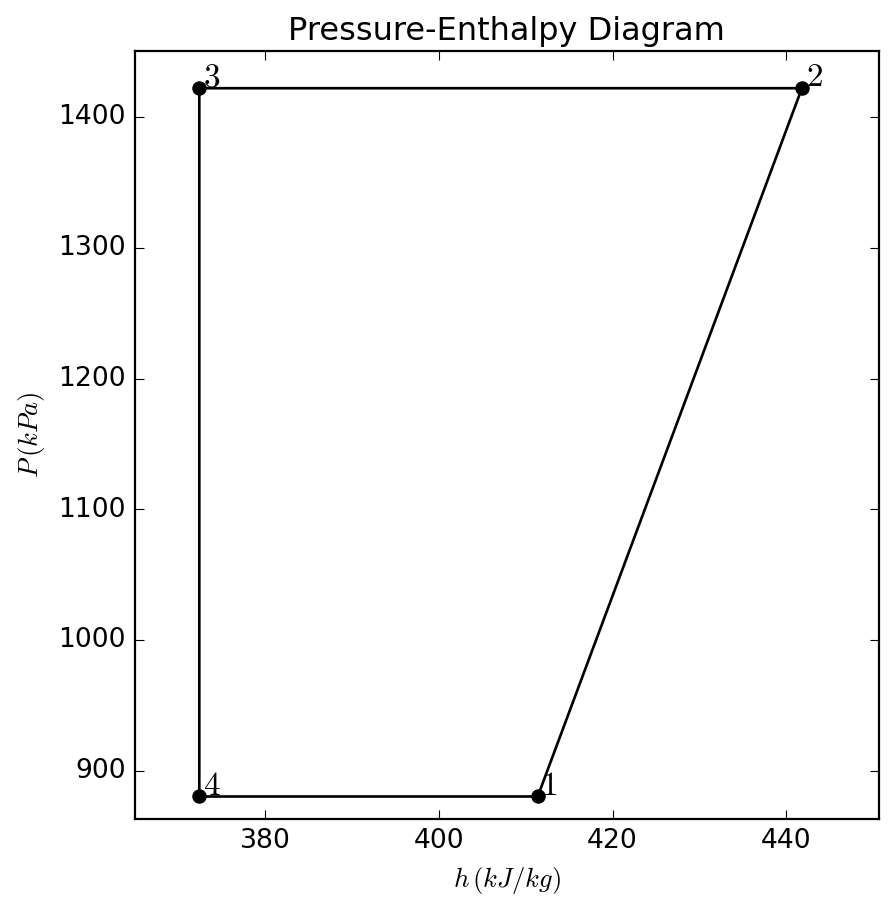

In [7]:
st3 = 15
T1 = 19 + 273.15
T2 = 44 + 273.15
T3 = 37 + 273.15
I = 7.35
COP3 = VCRC(T1, T2, T3, I)

### COP

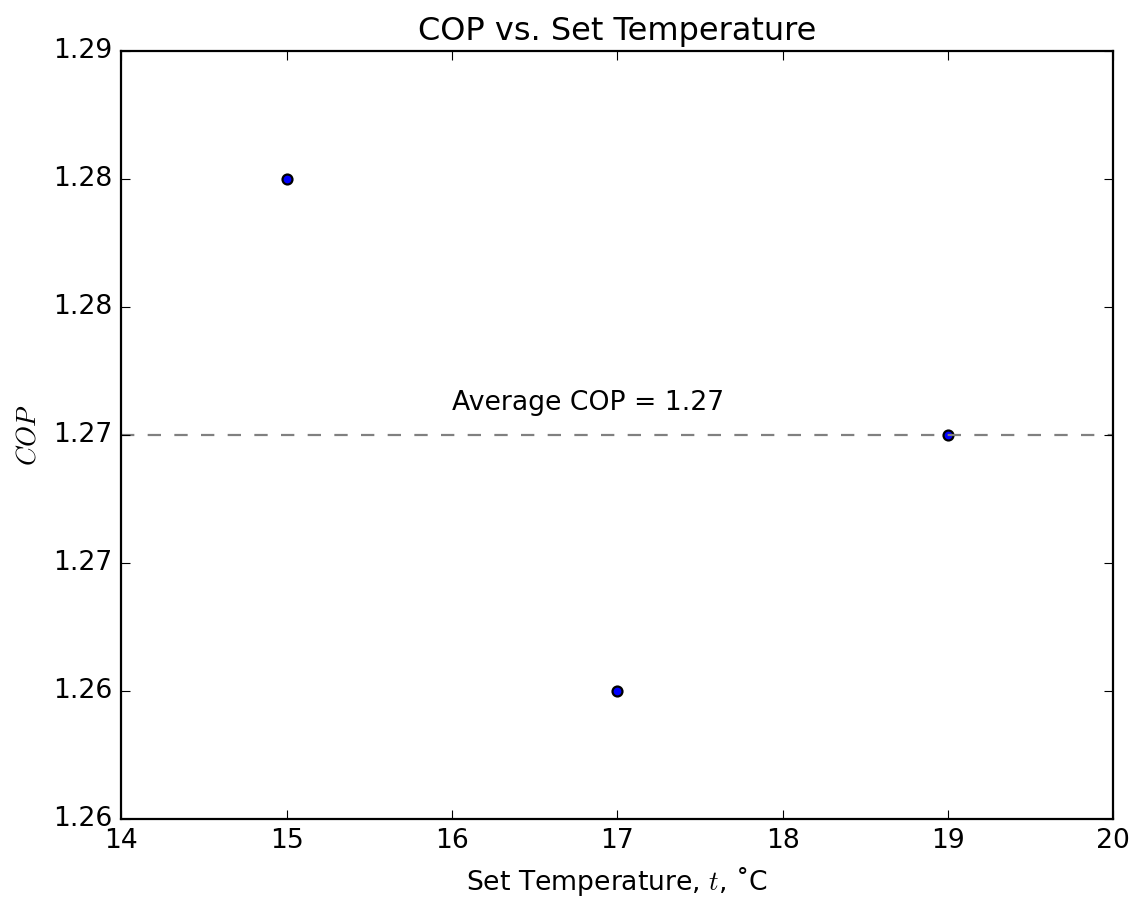

In [8]:
st = [st1, st2, st3]
COP = [COP1, COP2, COP3]
COP_avg = np.average(COP)

plt.figure(facecolor='white')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.title("COP vs. Set Temperature")
plt.scatter(st, COP)
plt.axhline(COP_avg, linestyle='--', color='grey')
plt.annotate('Average COP = %0.2f' % COP_avg, xy=(16, 1.271))
plt.xlabel(r"Set Temperature, $t$, ˚C")
plt.ylabel(r"$COP$");


---
### The End